# First part: ridge regression

In [910]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn import decomposition
from scipy.stats.stats import pearsonr 
from numpy import linalg

## Ridge regression

Ridge regression is a type of regression that introduces the concept of regularization through the alpha parameter in the ERM; at the end of this project we will see how to calibrate the value of this parameter

A regressor is a function

<img src = "images/regressor.png" width = "200">

 where <em>w</em> is a vector of real coefficients (weights), and <em>x</em> refers to the <em>x</em> component of training set

As anticipated before, the ERM is regularized by parameter <b>$\alpha$</b>

<img src= "images/ridge_regression.png" width = "350"/>

where S is the <b>design matrix</b>, the matrix of examples without labels

$\nabla(\left \| Sw - y \right \|^2 + \alpha \left \| w \right \|^2) = 2(S^TSw - S^Ty) + 2\alpha w$

since we want to minimize this function, let's set it equal to 0 and we obtain

$(S^TS + \alpha I)w = S^Ty$

$w = (S^TS + \alpha I)^{-1} S^Ty$

The regularization is needed since, without it, the vector is unstable; in particular, it can change a lot when the dataset is perturbed and let's keep in mind that we had to deal with missing values, hence we changed a fex examples and this could have led to a variance error.

### Estimator

In [911]:
class myRidgeRegressor(object):
    def __init__(self):
        pass
    
    def fit(self, S, y, alfa):
        self.w = linalg.inv(S.T.dot(S) + alfa * np.eye(S.shape[1])).dot(S.T.dot(y))
    
    def predict(self, x):
        return x.dot(self.w)

In [912]:
def square_loss(prediction, y):
    return (y - prediction) ** 2

In [913]:
def MSE(prediction, y):
    loss = square_loss(prediction, y)
    return 1/len(loss) * sum(loss)

In [914]:
final_results = pd.DataFrame([], 
                             columns=["test_error_d1", "r2_d1", "test_error_d2", "r2_d2", 
                                      "test_error_d3", "r2_d3", "test_error_d4", "r2_d4",
                                      "cross_val_d1", "cross_val_d2", "cross_val_d3", "cross_val_d4", 
                                      "cross_val_PCA_d1", "cross_val_PCA_d2", "cross_val_PCA_d3", "cross_val_PCA_d4",
                                      "nest_cross_val_d1", "best_alpha_d1", "nest_cross_val_d2", "best_alpha_d2",
                                      "nest_cross_val_d3", "best_alpha_d3", "nest_cross_val_d4", "best_alpha_d4",
                                     "sklearn_test_error_d1", "sklearn_cv_d1", "sklearn_test_error_d2", "sklearn_cv_d2",
                                     "sklearn_test_error_d3", "sklearn_cv_d3", "sklearn_test_error_d4", "sklearn_cv_d4"]
                            )

### Loading preprocessed datasets

Let's load the preprocessed datasets, we will handle 4 cases:
1. the complete dataset with replaced missing values normalized with min-max
2. the reduced dataset (missing values have been removed) with min-max normalization
3. the complete dataset with z-score normalization
4. the reduced dataset normalized with z-score

In [915]:
min_max_norm_dataset = pd.read_csv("datasets/min_max_norm_dataset")
min_max_norm_reduced_dataset = pd.read_csv("datasets/min_max_norm_reduced_dataset")

zscore_norm_dataset = pd.read_csv("datasets/zscore_norm_dataset")
zscore_norm_reduced_dataset = pd.read_csv("datasets/zscore_norm_reduced_dataset")

In [916]:
del min_max_norm_dataset["Unnamed: 0"]
del min_max_norm_reduced_dataset["Unnamed: 0"]
del zscore_norm_dataset["Unnamed: 0"]
del zscore_norm_reduced_dataset["Unnamed: 0"]

### Splitting in training and test set

In [917]:
def simple_split(dataset):
    y = dataset["median_house_value"]
    x = dataset.drop("median_house_value", axis = 1)
    return x, y

def split_dataset(dataset): # this splits also x and y into train and test sets randomly
    x, y = simple_split(dataset)
    return train_test_split(x, y, shuffle = True, test_size = 0.2)

Now we apply the ridge regressor for the 4 datasets and compute predictions, for this part it will be used $\alpha$ = 0.1

In [918]:
ridge_regressor = myRidgeRegressor()

### First dataset

In [986]:
min_max_norm_dataset = min_max_norm_dataset.sample(frac=1).reset_index(drop=True)
x_train, x_test, y_train, y_test = split_dataset(min_max_norm_dataset)

We fit the regressor with the training set, we obtain a w vector of weights that depends on alpha parameter

In [987]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.15781395, -0.09729711,  0.15335753, -0.34654083,  0.56761678,
       -0.79837758,  0.1685079 ,  0.74731389,  0.21924622])

and we can test the regressor on the test set to see how good predictions are done

In [988]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

14564    0.428237
12236    0.549381
10867    0.496056
6242     0.468918
1404     0.536873
13161    0.536825
4435     0.424782
11732    0.120046
12614    0.429098
2729     0.670373
dtype: float64

In [989]:
loss = square_loss(predictions, y_test)

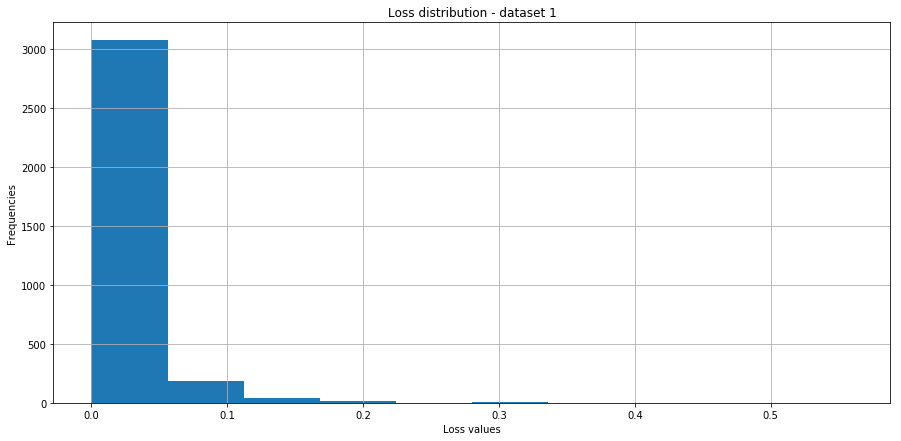

In [990]:
fig = plt.figure(figsize=(15, 7))
plt.title('Loss distribution - dataset 1')
plt.xlabel("Loss values")
plt.ylabel("Frequencies")
plt.hist(loss.values)
plt.grid()
fig.savefig("results/plots/loss_distribution_d1.png")
plt.show()
plt.close()

In [991]:
test_error = MSE(predictions, y_test)
test_error

0.017761474170639592

In [992]:
r2 = r2_score(y_test, predictions)
r2

0.5987346510820225

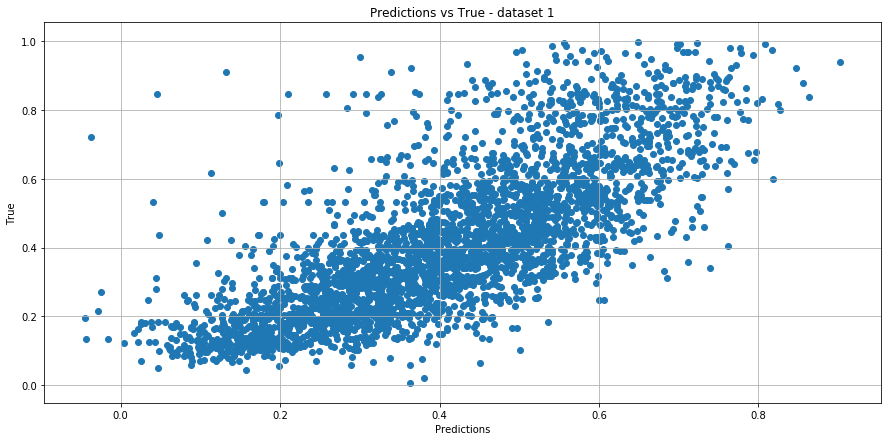

In [926]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.title('Predictions vs True - dataset 1')
plt.xlabel("Predictions")
plt.ylabel("True")
plt.grid()
fig.savefig("results/plots/predVStrue_d1.png")
plt.show()

In [927]:
update = pd.DataFrame([(test_error, r2)], columns=["test_error_d1", "r2_d1"])
final_results = final_results.append(update, sort = True)
final_results.reset_index()

,index,best_alpha_d1,best_alpha_d2,best_alpha_d3,best_alpha_d4,cross_val_PCA_d1,cross_val_PCA_d2,cross_val_PCA_d3,cross_val_PCA_d4,cross_val_d1,...,sklearn_cv_d3,sklearn_cv_d4,sklearn_test_error_d1,sklearn_test_error_d2,sklearn_test_error_d3,sklearn_test_error_d4,test_error_d1,test_error_d2,test_error_d3,test_error_d4
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019307,NaN,NaN,NaN


### Second dataset

In [928]:
min_max_norm_reduced_dataset = min_max_norm_reduced_dataset.sample(frac=1).reset_index(drop=True)
x_train, x_test, y_train, y_test = split_dataset(min_max_norm_reduced_dataset)

In [929]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.15744036, -0.09884297,  0.14990655, -0.34450287,  0.50668235,
       -0.81553565,  0.16761957,  0.75328245,  0.21575289])

In [930]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

4159    -0.046364
14608    0.552845
5122     0.597451
12394    0.335228
5380     0.257498
5093     0.217560
7905     0.662202
8254     0.381317
493      0.135549
4775     0.621369
dtype: float64

In [931]:
loss = square_loss(predictions, y_test)

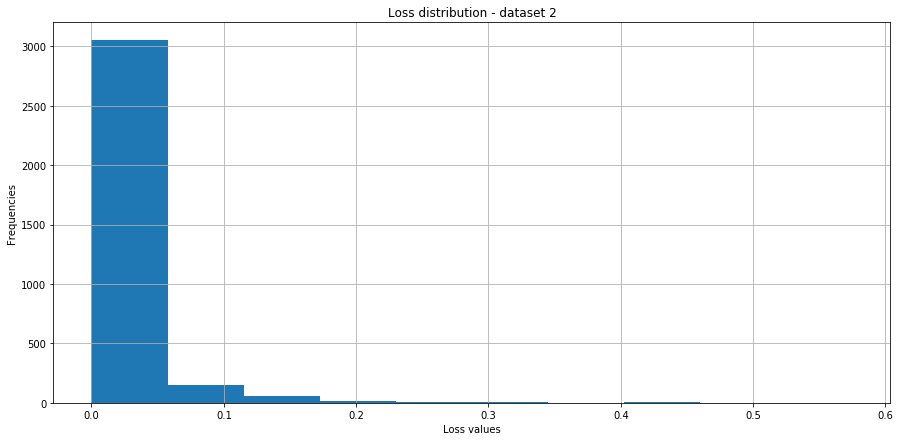

In [932]:
fig = plt.figure(figsize=(15, 7))
plt.title('Loss distribution - dataset 2')
plt.xlabel("Loss values")
plt.ylabel("Frequencies")
plt.hist(loss.values)
plt.grid()
fig.savefig("results/plots/loss_distribution_d2.png")
plt.show()

In [933]:
test_error = MSE(predictions, y_test)
test_error

0.01799507166058126

In [934]:
r2 = r2_score(y_test, predictions)
r2

0.5804758721580648

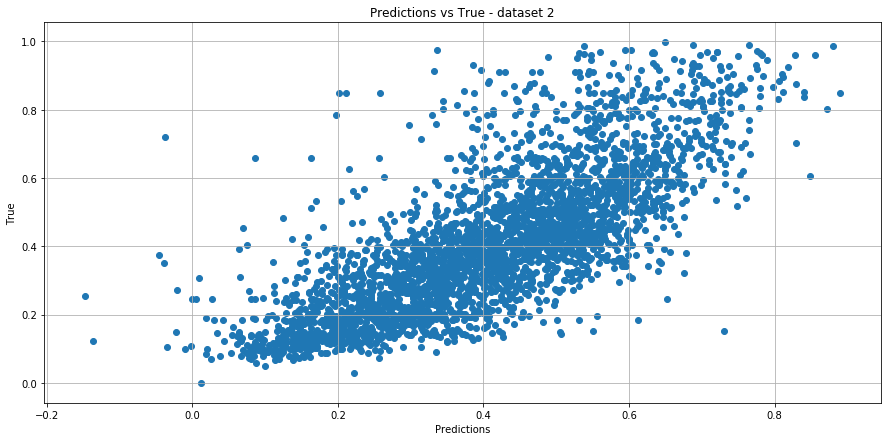

In [935]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.title('Predictions vs True - dataset 2')
plt.xlabel("Predictions")
plt.ylabel("True")
plt.grid()
fig.savefig("results/plots/predVStrue_d2.png")
plt.show()

In [936]:
final_results.test_error_d2 = test_error
final_results.r2_d2 = r2

### Third dataset

In [937]:
zscore_norm_dataset = zscore_norm_dataset.sample(frac=1).reset_index(drop=True)
x_train, x_test, y_train, y_test = split_dataset(zscore_norm_dataset)

In [938]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.5929875 , -0.59661179,  0.11711224, -0.25456425,  0.46054966,
       -0.27369354,  0.08547785,  0.63930586,  0.1568144 ])

In [939]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

12172    0.368367
2099     0.839100
11641   -0.375586
15891    0.805122
5804     0.763866
15727    0.478626
5082     0.406740
9093     0.135918
5482     0.249746
6263     1.021735
dtype: float64

In [940]:
loss = square_loss(predictions, y_test)

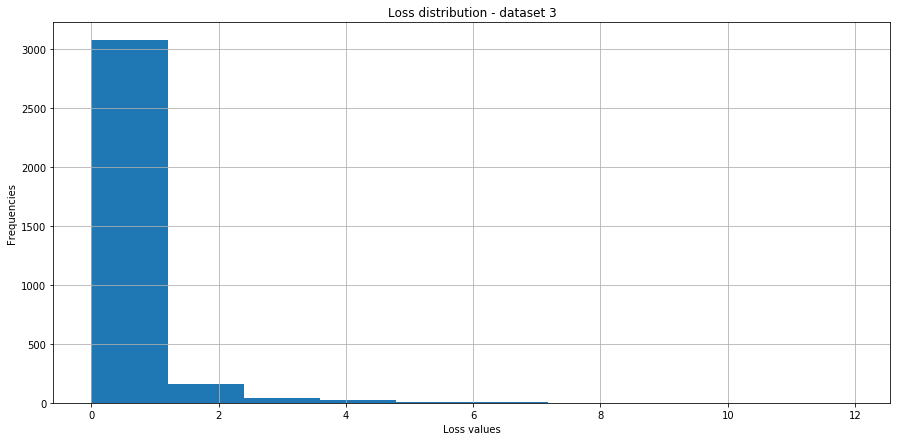

In [941]:
fig = plt.figure(figsize=(15, 7))
plt.title('Loss distribution - dataset 3')
plt.xlabel("Loss values")
plt.ylabel("Frequencies")
plt.hist(loss.values)
plt.grid()
fig.savefig("results/plots/loss_distribution_d3.png")
plt.show()

In [942]:
test_error = MSE(predictions, y_test)
test_error

0.37106860215075366

In [943]:
r2 = r2_score(y_test, predictions)
r2

0.6124436751419302

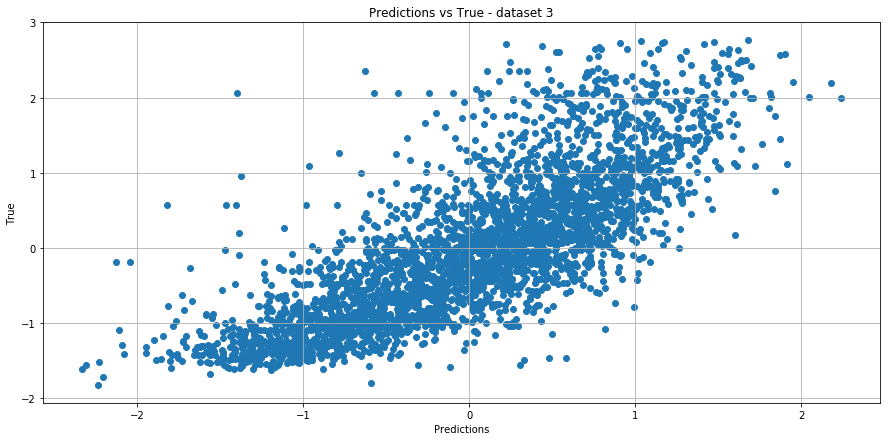

In [944]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.title('Predictions vs True - dataset 3')
plt.xlabel("Predictions")
plt.ylabel("True")
plt.grid()
fig.savefig("results/plots/predVStrue_d3.png")
plt.show()

In [945]:
final_results.test_error_d3 = test_error
final_results.r2_d3 = r2

### Fourth dataset

In [946]:
zscore_norm_reduced_dataset = zscore_norm_reduced_dataset.sample(frac=1).reset_index(drop=True)
x_train, x_test, y_train, y_test = split_dataset(zscore_norm_reduced_dataset)

In [947]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.60666224, -0.61304463,  0.11028766, -0.26125349,  0.46658454,
       -0.2836055 ,  0.08947757,  0.63972993,  0.15884168])

In [948]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

13711   -0.965572
3149    -0.931556
4400    -1.375816
2383     1.338389
13846   -0.559426
3903    -0.878619
10049    0.280104
8263    -0.628451
15332   -0.207545
10155    0.182191
dtype: float64

In [949]:
loss = square_loss(predictions, y_test)

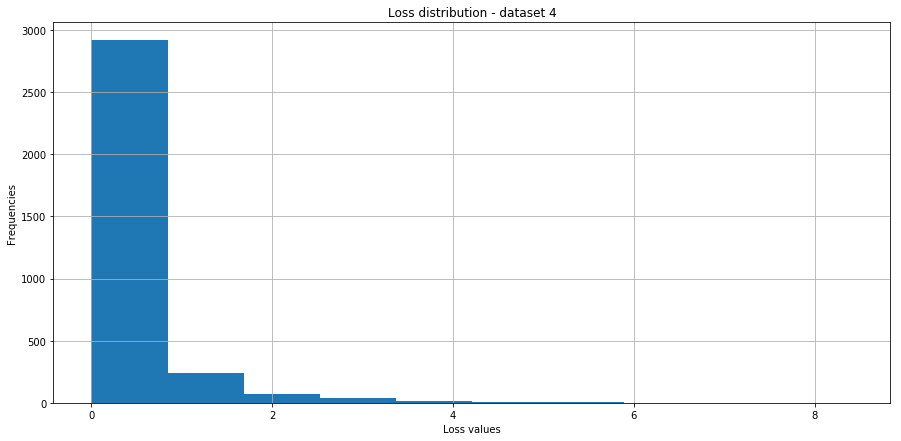

In [950]:
fig = plt.figure(figsize=(15, 7))
plt.title('Loss distribution - dataset 4')
plt.xlabel("Loss values")
plt.ylabel("Frequencies")
plt.hist(loss.values)
plt.grid()
fig.savefig("results/plots/loss_distribution_d4.png")
plt.show()

In [951]:
test_error = MSE(predictions, y_test)
test_error

0.3549681606308306

In [952]:
r2 = r2_score(y_test, predictions)
r2

0.6240578300669404

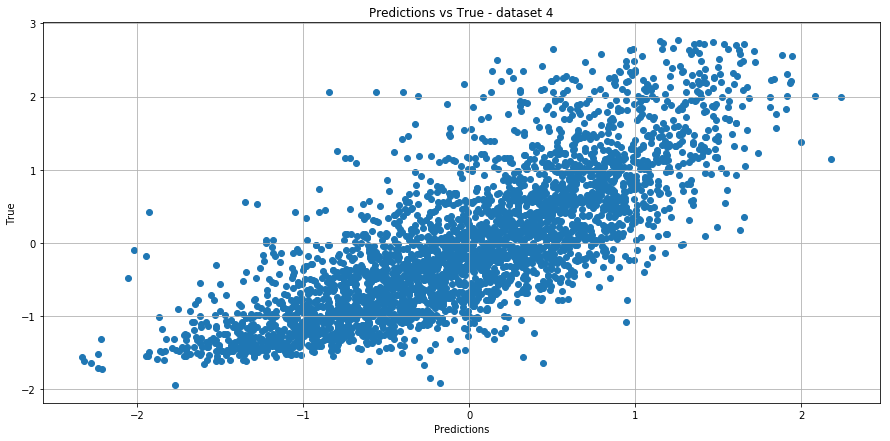

In [953]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.title('Predictions vs True - dataset 4')
plt.xlabel("Predictions")
plt.ylabel("True")
plt.grid()
fig.savefig("results/plots/predVStrue_d4.png")
plt.show()

In [954]:
final_results.test_error_d4 = test_error
final_results.r2_d4 = r2

We notice a relevant difference in test error between the first two datasets with respect to the last twos, which reveals that min max normalization produces better result than z-score.
For what it concerns the replacement of missing values, we notice very little difference.

# Second part: analysis

We are dealing with a learning problem $(D, l)$ where $l$ is the square loss:

- Let $h(S)$ be the prediction of predictor $h$ on training set $S$
- Let $l_D(h(S))$ be the risk of $h(S)$
- Let $E[l_D(h)]$ be the expected risk of $h(S)$ where the expectation is with respect to the random draw of training set $S$

Hence, $E[l_D(h)]$ measures the performance of $h$ on a random training set whereas $l_D(h(S))$ measures the performance of $h$ when the training set is $S$

## K-fold cross validation

We would like to estimate $E[l_D(h)]$ to see, in general, the goodness of our predictor; in order to do this, we can use k-fold cross validation:  
let $S$ be the entire dataset, we partition $S$ in $K$ subsets (called folds) $D_1, D_2, ..., D_K$ of size $m/K$ each where $m$ is the size of $S$ and we use $S^{(k)}$ as <b>training part</b> with $S^{(k)} \equiv S \setminus D_k$ where $D_k$ is the <b>testing part</b>;
we iterate this process for $k = 1 ... K$.

In [955]:
def cross_validation(dataset, K, alfa):   
    scores = []
    
    kf = KFold(n_splits = K, shuffle = True)
    
    for train_i, test_i in kf.split(dataset):
        
        X, y = simple_split(dataset)
        
        x_train, x_test = X.iloc[train_i], X.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]

        # learning with training part
        ridge_regressor.fit(x_train, y_train, alfa)

        # testing with testing part
        result = ridge_regressor.predict(x_test)
        scores.append(MSE(result, y_test))

    return scores

We try $K = 5$

Now let's compare the cv estimate for all 4 datasets we had before

In [956]:
cv_1 = np.mean(cross_validation(min_max_norm_dataset, K, 0.1))

cv_2 = np.mean(cross_validation(min_max_norm_reduced_dataset, K, 0.1))

cv_3 = np.mean(cross_validation(zscore_norm_dataset, K, 0.1))

cv_4 = np.mean(cross_validation(zscore_norm_reduced_dataset, K, 0.1))

print(cv_1, cv_2, cv_3, cv_4)

0.018370133063471905 0.018338484706274548 0.39138483468676777 0.39147774628585186


In [957]:
final_results.cross_val_d1 = cv_1
final_results.cross_val_d2 = cv_2
final_results.cross_val_d3 = cv_3
final_results.cross_val_d4 = cv_4

## Dependence of the cross-validated risk estimate on the parameter alpha

For simplicity, let's consider only one dataset, we will choose the one that showed the best performance with $ \alpha = 0.1$

We will test 5000 values for $\alpha$, from 0.1 to 499 with a step of 0.1

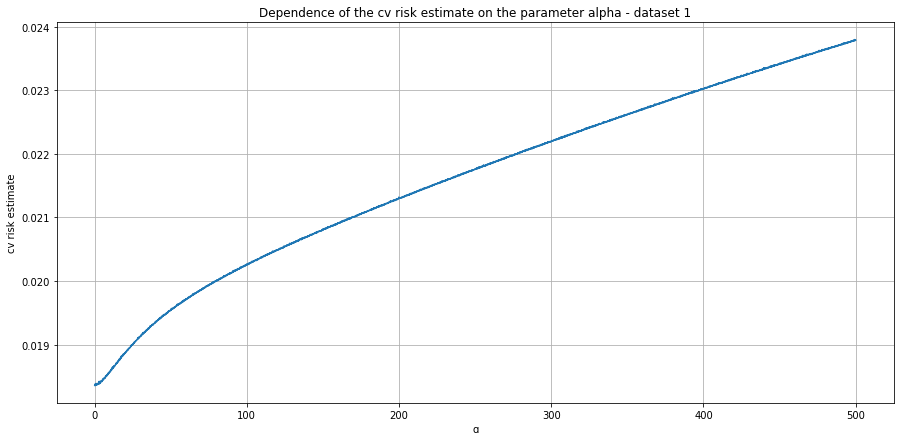

In [958]:
cv_scores = []
alfas = np.linspace(0.1, 500, 5000)

for i in alfas:
    cv_scores.append(np.mean(cross_validation(min_max_norm_dataset, 5, i)))
    
plt.figure(figsize=(15, 7))
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 1')
plt.plot(alfas, cv_scores)
plt.xlabel("ɑ")
plt.ylabel("cv risk estimate")
plt.grid()
plt.show()

From this plot we can conclude that the cv risk estimate increseas monotonically for $\alpha \rightarrow \infty$

Let's study the behavior of the risk estimate with the other 3 datasets

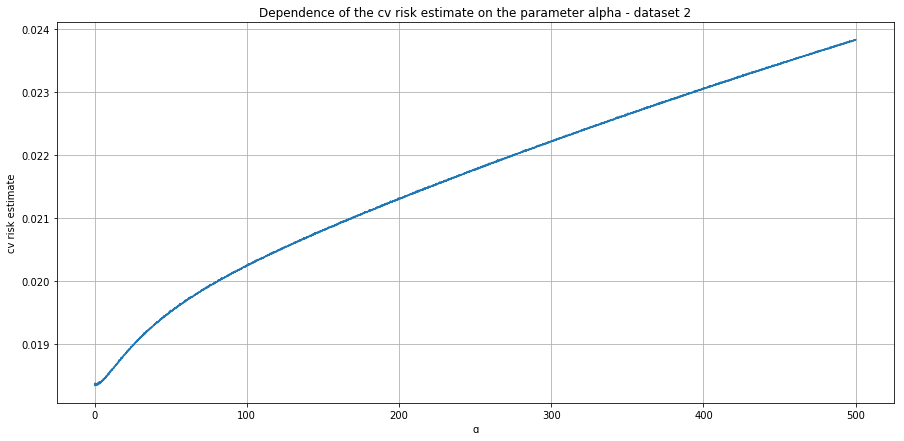

In [959]:
cv_scores = []
alfas = np.linspace(0.1, 500, 5000)

for i in alfas:
    cv_scores.append(np.mean(cross_validation(min_max_norm_reduced_dataset, 5, i)))
    
plt.figure(figsize=(15, 7))
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 2')
plt.plot(alfas, cv_scores)
plt.xlabel("ɑ")
plt.ylabel("cv risk estimate")
plt.grid()
plt.show()

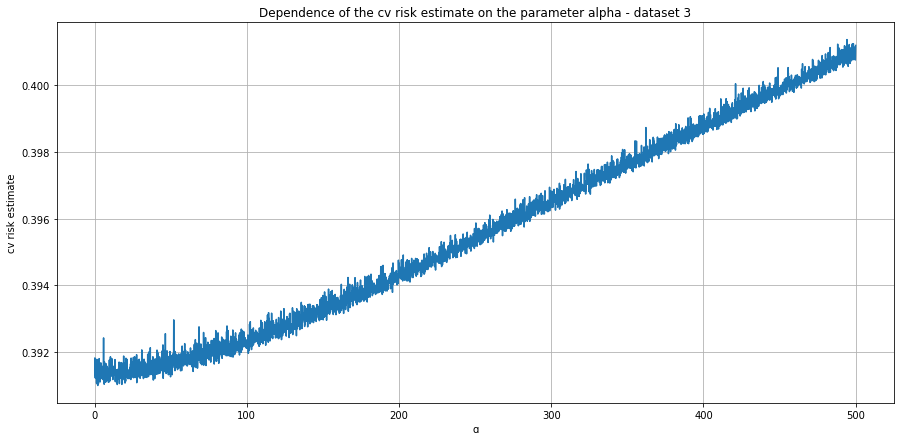

In [960]:
cv_scores = []
alfas = np.linspace(0.1, 500, 5000)

for i in alfas:
    cv_scores.append(np.mean(cross_validation(zscore_norm_dataset, 5, i)))
    
plt.figure(figsize=(15, 7))
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 3')
plt.plot(alfas, cv_scores)
plt.xlabel("ɑ")
plt.ylabel("cv risk estimate")
plt.grid()
plt.show()

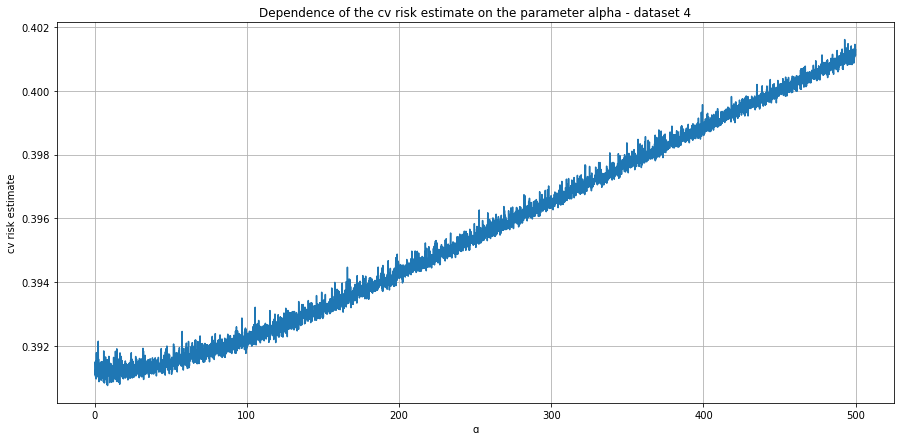

In [961]:
cv_scores = []
alfas = np.linspace(0.1, 500, 5000)

for i in alfas:
    cv_scores.append(np.mean(cross_validation(zscore_norm_reduced_dataset, 5, i)))
    
plt.figure(figsize=(15, 7))
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 4')
plt.plot(alfas, cv_scores)
plt.xlabel("ɑ")
plt.ylabel("cv risk estimate")
plt.grid()
plt.show()

This means that there is a dependence of positive linear relationship between cv risk estimate and parameter alpha, in order to confirm this let's compute the correlation coefficient (this is the last dataset):

In [962]:
pearsonr(alfas, cv_scores)[0]

0.9953438153142021

This is highly confirmed by the Pearson coefficient.

After this analysis we try to do ridge regression with $\alpha = 0.001$ and see what happens

In [963]:
cv_1 = np.mean(cross_validation(min_max_norm_dataset, K, 0.001))

cv_2 = np.mean(cross_validation(min_max_norm_reduced_dataset, K, 0.001))

cv_3 = np.mean(cross_validation(zscore_norm_dataset, K, 0.001))

cv_4 = np.mean(cross_validation(zscore_norm_reduced_dataset, K, 0.001))

print(cv_1, cv_2, cv_3, cv_4)

0.018369910391945854 0.018352578953176157 0.39154064211931094 0.3911932097040712


## Using PCA

In [964]:
def prediction_with_PCA(alfa, x_train, y_train, x_test, y_test):
    pca = decomposition.PCA(n_components=7)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    ridge_regressor.fit(x_train_pca, y_train, alfa)
    predictions = ridge_regressor.predict(x_test_pca)
    test_error = MSE(predictions, y_test)
    return test_error

Now we can update our previous function of cross correlation by adding the PCA procedure

In [965]:
def cross_validation_with_PCA(dataset, K, alfa):   
    scores = []
    
    kf = KFold(n_splits = K, shuffle = True)
    
    for train_i, test_i in kf.split(dataset):
        
        X, y = simple_split(dataset)
        
        x_train, x_test = X.iloc[train_i], X.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]

        # learning with training part
        ridge_regressor.fit(x_train, y_train, alfa)

        # testing with testing part
        # UPDATE
        pca_score = prediction_with_PCA(alfa, x_train, y_train, x_test, y_test)        
        
        scores.append(pca_score)

    return scores

In [966]:
cv_1 = np.mean(cross_validation_with_PCA(min_max_norm_dataset, K, 0.001))

cv_2 = np.mean(cross_validation_with_PCA(min_max_norm_reduced_dataset, K, 0.001))

cv_3 = np.mean(cross_validation_with_PCA(zscore_norm_dataset, K, 0.001))

cv_4 = np.mean(cross_validation_with_PCA(zscore_norm_reduced_dataset, K, 0.001))

print(cv_1, cv_2, cv_3, cv_4)

0.18830012271333177 0.18816574497933553 0.40620595680021454 0.4063564969527952


In [967]:
final_results.cross_val_PCA_d1 = cv_1
final_results.cross_val_PCA_d2 = cv_2
final_results.cross_val_PCA_d3 = cv_3
final_results.cross_val_PCA_d4 = cv_4

## optional: try nested CV to avoid choosing alpha

We are at the end of this notebook, and we want to perform nested cross validation in order to select automatically the best value for $\alpha$.  
From the previous plots we predict that the best value will be the closest value towards 0.

Nested cross validation works by adding at each iteration an inner cross validation where the algorithm tries a range of values for the hyperparameter, in this case $\alpha$, this means that each training part of $(m/K) * (K-1)$ size, is splitted in $L$ folds.    
Consequently, we want $(m/K) * (K-1)$ to be divisible by $L$.

In [968]:
L = 4
print(int(m/K) * (K-1), L)

13144 4


In [969]:
def nested_cross_validation(dataset, K, L, alfas):   
    best_result = 1000000000000
    best_alfa = 10000000000000
    scores = []
    
    kf = KFold(n_splits = K, shuffle = True)
    
    for train_i, test_i in kf.split(dataset):
        kf = KFold(n_splits = L, shuffle = True)
        
        for inner_train_i, inner_test_i in kf.split(dataset.iloc[train_i]):
            
            inner_X, inner_y = simple_split(dataset)
        
            inner_x_train, inner_x_test = inner_X.iloc[train_i], inner_X.iloc[test_i]
            inner_y_train, inner_y_test = inner_y.iloc[train_i], inner_y.iloc[test_i]
        
            inner_scores = []
                   
            for alf in alfas:
                # learning with training part
                ridge_regressor.fit(inner_x_train, inner_y_train, alf)

                # testing with testing part
                inner_result = ridge_regressor.predict(inner_x_test)
                inner_scores.append(MSE(inner_result, inner_y_test))
                
            average_inner_score = np.mean(inner_scores)
            best_inner_result = min(inner_scores) # the best result
            best_inner_result_position = inner_scores.index(best_inner_result) 
            best_inner_alfa = alfas[best_inner_result_position] # the best alfa
            
            if best_inner_result < best_result: # store the current best result obtained and update it if better
                best_result = best_inner_result
                best_alfa = best_inner_alfa
                
        X, y = simple_split(dataset)
        
        x_train, x_test = X.iloc[train_i], X.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]
                
        # learning with training part
        ridge_regressor.fit(x_train, y_train, best_alfa)

        # testing with testing part
        result = ridge_regressor.predict(x_test)
        scores.append(MSE(result, y_test))

    return scores, best_alfa

Now we can find the best value of $\alpha$ in the range $(0.01 - 20)$ for the four datasets

In [970]:
nest_cv_1, best_alfa = nested_cross_validation(min_max_norm_dataset, 5, 4, np.linspace(0.01, 20, 2000))
nest_cv_1 = np.mean(nest_cv_1)
print(nest_cv_1, best_alfa)

0.018359614928424008 0.01


In [971]:
final_results.nest_cross_val_d1 = nest_cv_1
final_results.best_alpha_d1 = best_alfa

In [972]:
nest_cv_2, best_alfa = nested_cross_validation(min_max_norm_reduced_dataset, 5, 4, np.linspace(0.01, 20, 2000))
nest_cv_2 = np.mean(nest_cv_2)
print(nest_cv_2, best_alfa)

0.01834205036802573 0.01


In [973]:
final_results.nest_cross_val_d2 = nest_cv_2
final_results.best_alpha_d2 = best_alfa

In [974]:
nest_cv_3, best_alfa = nested_cross_validation(zscore_norm_dataset, 5, 4, np.linspace(0.01, 20, 2000))
nest_cv_3 = np.mean(nest_cv_3)
print(nest_cv_3, best_alfa)

0.3912851052182452 0.01


In [975]:
final_results.nest_cross_val_d3 = nest_cv_3
final_results.best_alpha_d3 = best_alfa

In [976]:
nest_cv_4, best_alfa = nested_cross_validation(zscore_norm_reduced_dataset, 5, 4, np.linspace(0.01, 20, 2000))
nest_cv_4 = np.mean(nest_cv_4)
print(nest_cv_4, best_alfa)

0.391075386405101 0.01


In [977]:
final_results.nest_cross_val_d4 = nest_cv_4
final_results.best_alpha_d4 = best_alfa

And we find out with a certain accuracy the best alpha configuration that achieves the risk minimization

# Consistency with existing libraries

With the aim of validating the work done let's import the existing libraries that have been developed in this branch and let's see if the results are consistent

In [978]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate

ridge = Ridge(alpha = 0.1)

min_max_norm_dataset = min_max_norm_dataset.sample(frac=1).reset_index(drop=True)

x_train, x_test, y_train, y_test = split_dataset(min_max_norm_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
mse = MSE(results, y_test)
print("MSE: ", mse)

cv = - np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score'])
X, y = simple_split(min_max_norm_dataset)
print("CV: ", cv)

final_results.sklearn_test_error_d1 = mse
final_results.sklearn_cv_d1 = cv
print("")

min_max_norm_reduced_dataset = min_max_norm_reduced_dataset.sample(frac=1).reset_index(drop=True)

x_train, x_test, y_train, y_test = split_dataset(min_max_norm_reduced_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
mse = MSE(results, y_test)
print("MSE: ", mse)

cv = - np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score'])
X, y = simple_split(min_max_norm_reduced_dataset)
print("CV: ", cv)

final_results.sklearn_test_error_d2 = mse
final_results.sklearn_cv_d2 = cv
print("")

zscore_norm_dataset = zscore_norm_dataset.sample(frac=1).reset_index(drop=True)

x_train, x_test, y_train, y_test = split_dataset(zscore_norm_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
mse = MSE(results, y_test)
print("MSE: ", mse)

cv = - np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score'])
X, y = simple_split(zscore_norm_dataset)
print("CV: ", cv)

final_results.sklearn_test_error_d3 = mse
final_results.sklearn_cv_d3 = cv
print("")

zscore_norm_reduced_dataset = zscore_norm_reduced_dataset.sample(frac=1).reset_index(drop=True)

x_train, x_test, y_train, y_test = split_dataset(zscore_norm_reduced_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
mse = MSE(results, y_test)
print("MSE: ", mse)

cv = - np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score'])
X, y = simple_split(zscore_norm_reduced_dataset)
print("CV: ", cv)

final_results.sklearn_test_error_d4 = mse
final_results.sklearn_cv_d4 = cv

MSE:  0.01719751851032016
CV:  0.3910958096375277

MSE:  0.01812410335127753
CV:  0.01762421771692691

MSE:  0.38434687863422595
CV:  0.017595745912337604

MSE:  0.3951814753896988
CV:  0.39134688010255897


In [994]:
final_results.to_csv("results/scores/final_scores.csv")

In [995]:
final_results.iloc[:, range(0, 8)]

,best_alpha_d1,best_alpha_d2,best_alpha_d3,best_alpha_d4,cross_val_PCA_d1,cross_val_PCA_d2,cross_val_PCA_d3,cross_val_PCA_d4
0,0.01,0.01,0.01,0.01,0.1883,0.188166,0.406206,0.406356


In [1003]:
final_results.iloc[:, range(8, 16)]

,cross_val_d1,cross_val_d2,cross_val_d3,cross_val_d4,nest_cross_val_d1,nest_cross_val_d2,nest_cross_val_d3,nest_cross_val_d4
0,0.01837,0.018338,0.391385,0.391478,0.01836,0.018342,0.391285,0.391075


In [1000]:
final_results.iloc[:, range(16, 25)]

,r2_d1,r2_d2,r2_d3,r2_d4,r^2_d1,sklearn_cv_d1,sklearn_cv_d2,sklearn_cv_d3,sklearn_cv_d4
0,0.598735,0.580476,0.612444,0.624058,0.57478,0.391096,0.017624,0.017596,0.391347


In [1001]:
final_results.iloc[:, range(25, 33)]

,sklearn_test_error_d1,sklearn_test_error_d2,sklearn_test_error_d3,sklearn_test_error_d4,test_error_d1,test_error_d2,test_error_d3,test_error_d4
0,0.017198,0.018124,0.384347,0.395181,0.019307,0.017995,0.371069,0.354968
